In [123]:

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string
import pandas as pd

from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FourPeaks, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner
from A2_helpers.Four_peaks_helpers import Runner_overSeeds
import pandas as pd


# switch off the chatter
logging.basicConfig(level=logging.WARNING)

# fitness funcions list
#https://mlrose.readthedocs.io/en/stable/source/fitness.html#fitness

# about the mlrose setup
#https://mlrose.readthedocs.io/en/stable/source/tutorial1.html

# algos
# https://mlrose.readthedocs.io/en/stable/source/algorithms.html#algs


# Fitness / Iteration: Since we're dealing with optimization problems, those problems will present access to a fitness score at each iteration.

# Fitness / Problem Size: Focusing on a single problem size can misrepresent how well an algorithm is actually doing. To counteract this, try multiple problem sizes.

# Function Evaluations: There's many ways to interpret fevals. Some students will focus on fevals / wall clock times, or fevals / iterations, etc. The real requirement is that you somehow look at fevals. Keep in mind that some algorithms may take significantly less iterations but each iteration may take significantly longer.

# Wall Clock Time: Our favorite. Look into it.

In [157]:
def increase_font_size(plt, label_fontsize=14*1.3, title_fontsize=16*1.3, legend_fontsize=12*1.3, tick_fontsize=12*1.3):
    """
    Increases the font size for labels, title, legend, and tick labels of the current plot.
    
    Parameters:
    plt (module): The Matplotlib pyplot module.
    label_fontsize (int): Font size for the x and y labels.
    title_fontsize (int): Font size for the title.
    legend_fontsize (int): Font size for the legend.
    tick_fontsize (int): Font size for the tick labels.
    """
    ax = plt.gca()
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_fontsize)
    ax.set_title(ax.get_title(), fontsize=title_fontsize)
    ax.legend(prop={'size': legend_fontsize})
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

## RHC Graphs

Collect Data Ran from A2P1Collection notebook

In [158]:
#kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [5,10,20,40,80],  "experiment_name": "RHC_runner"} 
# hyperparameters above
rhc_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_rhc.csv")
rhc_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_rhc.csv")

In [159]:
#kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [5,10,20,40,80],  "experiment_name": "RHC_runner"} 
# hyperparameters above
rhc_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_rhc.csv")
rhc_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_rhc.csv")

In [160]:
# only look at the first restart for consistency
rhc_stats_all = rhc_stats_all[rhc_stats_all["current_restart"] == 0]

In [161]:
rhc_stats_all


,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart,seed,problem_size
0,0,0,1.0,0,0.000169,"[3, 4, 0, 1, 3]",1,1024,0,1,5
1,1,1,1.0,1,0.001991,"[3, 4, 0, 1, 3]",1,1024,0,1,5
2,2,2,2.0,3,0.003289,"[3, 0, 0, 1, 3]",1,1024,0,1,5
3,3,4,3.0,6,0.004792,"[3, 3, 0, 1, 3]",1,1024,0,1,5
4,4,8,4.0,11,0.006485,"[3, 3, 1, 1, 3]",1,1024,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
559,7,64,43.0,80,0.020435,"[9, 15, 0, 28, 25, 29, 29, 22, 29, 13, 16, 29,...",1,1024,0,10,35
560,8,128,54.0,149,0.035916,"[9, 13, 13, 28, 25, 29, 29, 29, 29, 13, 16, 29...",1,1024,0,10,35
561,9,256,72.0,284,0.067170,"[9, 29, 13, 28, 22, 29, 29, 29, 29, 13, 29, 29...",1,1024,0,10,35
562,10,512,128.0,554,0.141935,"[22, 29, 13, 29, 22, 29, 29, 29, 29, 29, 29, 2...",1,1024,0,10,35


In [162]:
average_fitness_per_iteration = rhc_stats_all.groupby(['problem_size', 'Iteration'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = rhc_stats_all.groupby(['problem_size', 'Iteration'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness_rhc = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
min_iteration_for_max_fitness_rhc


,problem_size,Iteration,Average_Fitness,Std_Fitness
0,5,64,10.000000,0.000000
5,15,512,91.666667,9.933110
7,25,1024,193.000000,15.760711
8,35,1024,213.333333,47.259567


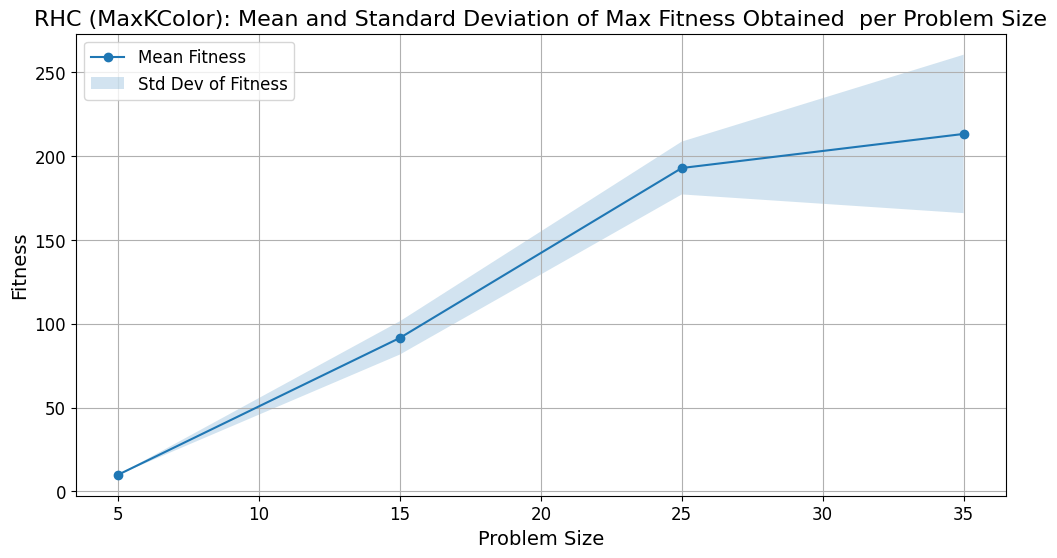

In [163]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(rhc_stats_all['problem_size'].unique(), min_iteration_for_max_fitness_rhc["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_rhc["problem_size"], 
                 min_iteration_for_max_fitness_rhc["Average_Fitness"] - min_iteration_for_max_fitness_rhc["Std_Fitness"], 
                 min_iteration_for_max_fitness_rhc["Average_Fitness"]+ min_iteration_for_max_fitness_rhc["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('RHC (MaxKColor): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
increase_font_size(plt, label_fontsize=14, title_fontsize=16, legend_fontsize=12, tick_fontsize=12)
plt.show()

    Iteration       mean       std
0           0   1.333333  0.516398
1           1   2.000000  0.894427
2           2   2.333333  0.516398
3           4   3.166667  0.752773
4           8   3.833333  1.329160
5          16   5.333333  1.032796
6          32   8.000000  2.190890
7          64  10.000000  0.000000
8         128  10.000000  0.000000
9         256  10.000000  0.000000
10        512  10.000000  0.000000
11       1024  10.000000  0.000000
    Iteration       mean        std
0           0   7.333333   1.505545
1           1   8.000000   1.264911
2           2   8.833333   0.983192
3           4   9.666667   1.211060
4           8  11.000000   2.190890
5          16  13.833333   2.857738
6          32  17.000000   3.794733
7          64  27.000000   5.440588
8         128  39.500000   6.892024
9         256  64.166667  11.956867
10        512  91.666667   9.933110
11       1024  91.666667   9.933110
    Iteration        mean        std
0           0   11.500000   2.880972
1  

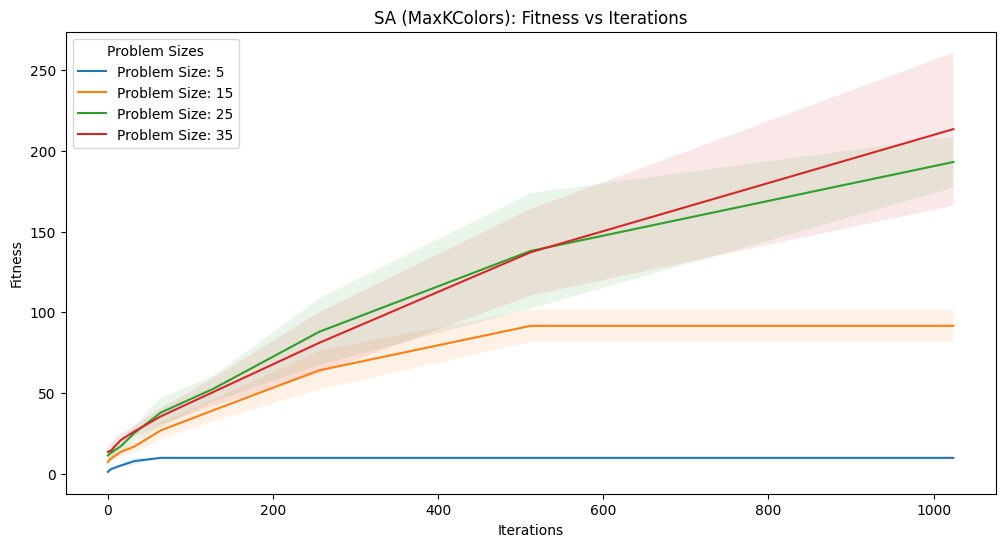

In [164]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in rhc_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_rhc[min_iteration_for_max_fitness_rhc["problem_size"] == size]

    
    # Further filter the main DataFrame for these best hyperparameters
    df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                    
                    ]
   
    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    print(df_grouped)

    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Fitness vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()


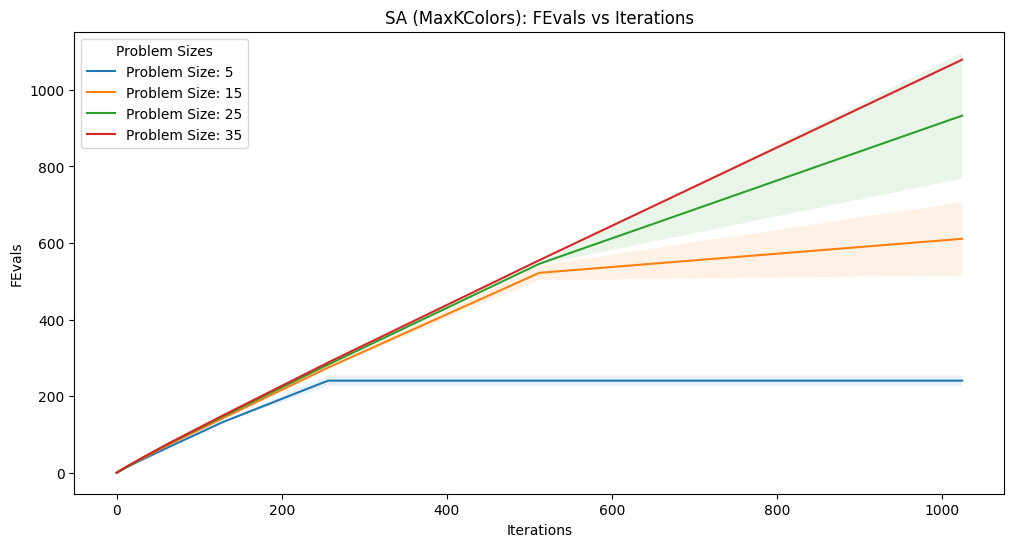

In [165]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in rhc_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_rhc[min_iteration_for_max_fitness_rhc["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                    ]
    
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('SA (MaxKColors): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()

In [166]:
# the the best avg. max fitness for each problem size

grouped_df = rhc_stats_all.groupby(["problem_size", 'Iteration'])[['Time','Fitness']].mean()

# Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
grouped_df_mean = grouped_df.groupby(["problem_size", 'Iteration'])[['Time','Fitness']].mean().reset_index()

grouped_df_std = rhc_stats_all.groupby(["problem_size", 'Iteration'])[['Time','Fitness']].std().reset_index()


# Finding the first occurrence of max Fitness for each problem size
max_fitness_first_occurrence = grouped_df_mean.loc[grouped_df_mean.groupby("problem_size")['Fitness'].idxmax()]

# get the max of the std
max_fitness_first_occurrence_std = grouped_df_std.loc[grouped_df_mean.groupby("problem_size")['Fitness'].idxmax()][["Time"]]

# relabel the column Time to Time Std
max_fitness_first_occurrence_std.rename(columns={'Time': 'Time Std'}, inplace=True)

# merge the two dataframes
max_fitness_first_occurrence = max_fitness_first_occurrence.merge(max_fitness_first_occurrence_std, left_index=True, right_index=True)
# Getting the corresponding Time values at those points
max_fitness_times = max_fitness_first_occurrence[['problem_size', 'Iteration', 'Time', 'Fitness', 'Time Std']]

print("Wall-Clock time per problem size (For all seeds and retries) by the team it reached avg. max Fitness")

max_fitness_times

Wall-Clock time per problem size (For all seeds and retries) by the team it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness,Time Std
7,5,64,0.007318,10.000000,0.002511
22,15,512,0.077790,91.666667,0.025369
35,25,1024,0.247386,193.000000,0.051907
47,35,1024,0.370337,213.333333,0.026637


In [167]:
print("Avg. Wall-Clock time per problem size (For all seeds and retries) On the 1024th iteration")
rhc_stats_all[rhc_stats_all["Iteration"]==1024].groupby(["problem_size"])["Time"].mean()

Avg. Wall-Clock time per problem size (For all seeds and retries) On the 1024th iteration


problem_size
5     0.022312
15    0.098860
25    0.247386
35    0.370337
Name: Time, dtype: float64

# SA: Graphs 

In [168]:

sa_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_sa.csv")
sa_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_sa.csv")

In [169]:
sa_stats_all

,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_exp_const,schedule_min_temp,schedule_current_value,Temperature,max_iters,schedule_decay,seed,problem_size
0,0,0,1.0,0,0.000125,"[3, 4, 0, 1, 3]",exponential,0.1,0.005,0.001,0.100000,0.1,1024,NaN,1,5
1,1,1,1.0,2,0.001563,"[0, 4, 0, 1, 3]",exponential,0.1,0.005,0.001,0.099999,0.1,1024,NaN,1,5
2,2,2,1.0,4,0.002642,"[0, 4, 0, 1, 2]",exponential,0.1,0.005,0.001,0.099999,0.1,1024,NaN,1,5
3,3,4,2.0,8,0.003840,"[0, 4, 0, 1, 4]",exponential,0.1,0.005,0.001,0.099998,0.1,1024,NaN,1,5
4,4,8,3.0,15,0.004881,"[3, 1, 1, 1, 4]",exponential,0.1,0.005,0.001,0.099998,0.1,1024,NaN,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,139,64,11.0,123,0.100380,"[4, 15, 0, 32, 23, 29, 17, 25, 9, 12, 16, 12, ...",geometric,5.0,NaN,0.001,4.994958,5.0,1024,0.99,10,35
3452,140,128,27.0,238,0.134267,"[15, 15, 12, 27, 22, 8, 18, 24, 25, 12, 24, 12...",geometric,5.0,NaN,0.001,4.993257,5.0,1024,0.99,10,35
3453,141,256,50.0,420,0.194754,"[7, 6, 12, 12, 4, 18, 18, 6, 25, 12, 24, 12, 2...",geometric,5.0,NaN,0.001,4.990223,5.0,1024,0.99,10,35
3454,142,512,105.0,721,0.291483,"[4, 6, 12, 12, 4, 12, 4, 6, 4, 12, 18, 4, 19, ...",geometric,5.0,NaN,0.001,4.985374,5.0,1024,0.99,10,35


In [170]:
average_fitness_per_iteration = sa_stats_all.groupby(['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = sa_stats_all.groupby(['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness_sa = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
print("best hyperparameters and avg fitness for each problem size")
min_iteration_for_max_fitness_sa

best hyperparameters and avg fitness for each problem size


,problem_size,Iteration,schedule_init_temp,schedule_type,Average_Fitness,Std_Fitness
0,5,64,0.1,exponential,10.000000,0.000000
34,15,1024,0.1,exponential,103.000000,0.000000
41,25,1024,0.1,exponential,209.166667,24.830760
43,35,1024,2.0,exponential,215.666667,39.520459


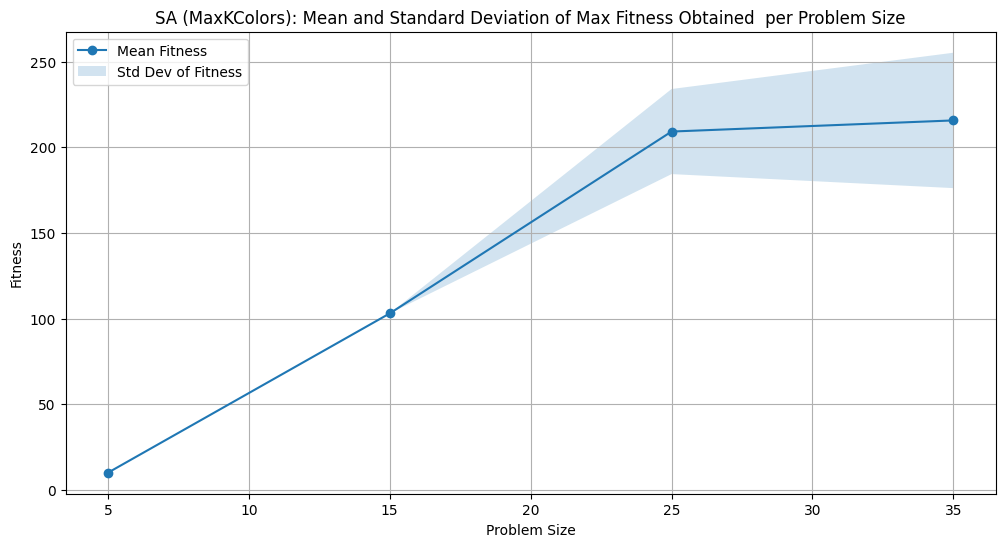

In [171]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(sa_stats_all["problem_size"].unique(), min_iteration_for_max_fitness_sa["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_sa["problem_size"], 
                 min_iteration_for_max_fitness_sa["Average_Fitness"] - min_iteration_for_max_fitness_sa["Std_Fitness"], 
                 min_iteration_for_max_fitness_sa["Average_Fitness"]+ min_iteration_for_max_fitness_sa["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
plt.show()

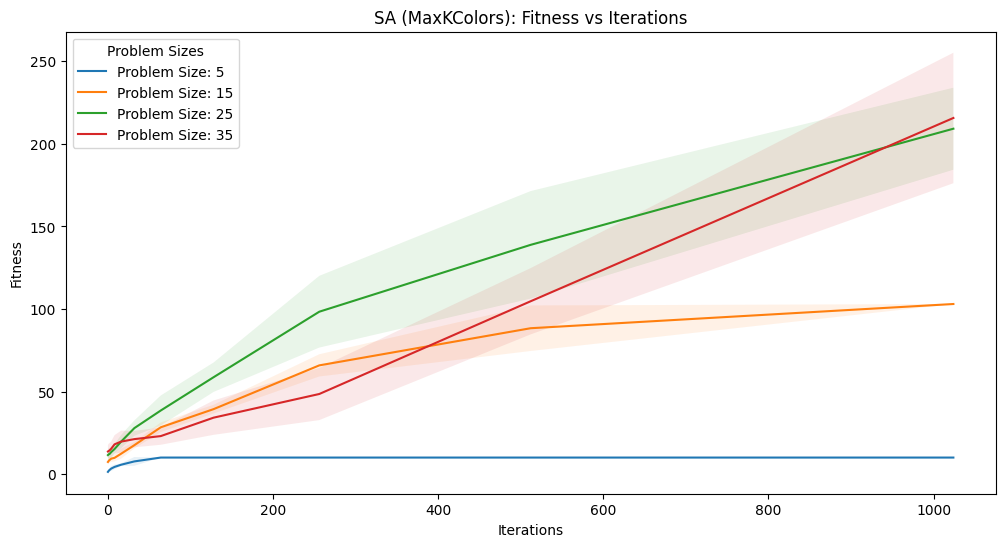

In [172]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                      (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]
    
    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Fitness vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()



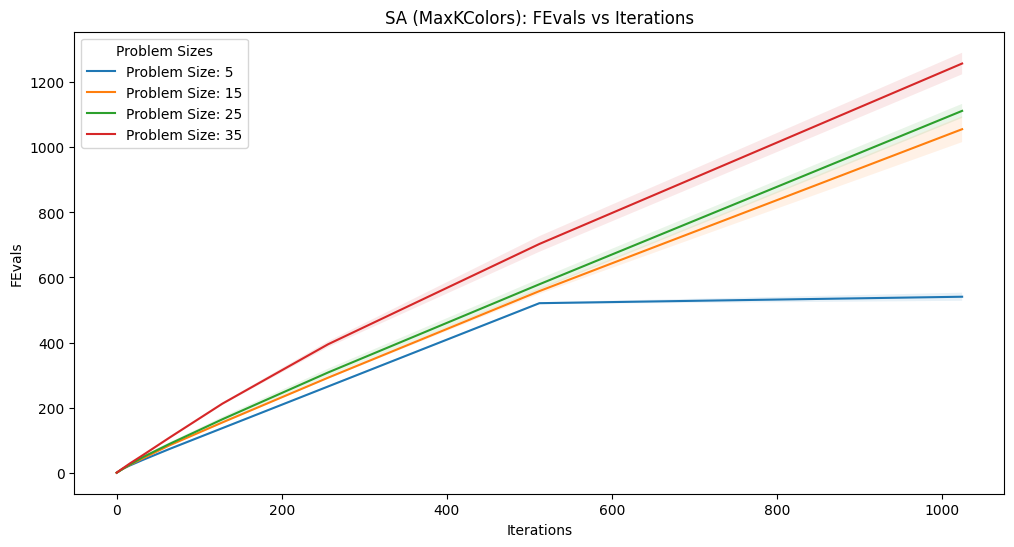

In [173]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                      (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]
    
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('SA (MaxKColors): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()


In [174]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"].isin(best_hyper_params["schedule_init_temp"])) & 
                      (sa_stats_all["schedule_type"].isin(best_hyper_params["schedule_type"])) &
                        (sa_stats_all["Iteration"].isin(best_hyper_params["Iteration"]))]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
    
        # getting grouped std
    grouped_df_std = df.groupby(["problem_size", 'Iteration'])[['Time']].std().reset_index()
    
    max_fitness_first_occurrence_std = grouped_df_std.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    max_fitness_first_occurrence_std.rename(columns={'Time': 'Time Std'}, inplace=True)
    # merge the two dataframes
    max_fitness_first_occurrence = pd.merge(max_fitness_first_occurrence, max_fitness_first_occurrence_std, on=['problem_size', 'Iteration'])
    
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])

# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)

# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness,Time Std
0,5,64,0.009697,10.000000,0.003879
1,15,1024,0.203491,103.000000,0.025944
2,25,1024,0.281019,209.166667,0.014124
3,35,1024,0.477912,215.666667,0.015513


In [175]:
iteration_1024_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"].isin(best_hyper_params["schedule_init_temp"])) & 
                      (sa_stats_all["schedule_type"].isin(best_hyper_params["schedule_type"])) & 
                      (sa_stats_all["Iteration"] == 1024)]
    
    # Calculate the mean and standard deviation of Time and Fitness for iteration 1024
    df_grouped = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Append the result to the final DataFrame
    iteration_1024_times_all = pd.concat([iteration_1024_times_all, df_grouped])
print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the 1024th iteration")
# Reset the index of the final DataFrame
iteration_1024_times_all.reset_index(drop=True, inplace=True)
iteration_1024_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the 1024th iteration


,problem_size,Iteration,Time,Fitness
0,5,1024,0.059410,10.000000
1,15,1024,0.203491,103.000000
2,25,1024,0.281019,209.166667
3,35,1024,0.477912,215.666667


## GA Graphs

In [176]:

ga_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_ga.csv")
ga_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_ga.csv")
	#problem_size	Iteration	Population Size	Mutation Rate
    # 5	              4	                     50	  0.10	
ga_stats_all[ (ga_stats_all["problem_size"]==5) & (ga_stats_all["Mutation Rate"]==0.1) & (ga_stats_all["Population Size"]==50) & (ga_stats_all["Iteration"]==16) ]

#problem_size	Iteration	Population Size	Mutation Rate
# 15	          128	         30	          0.50	
ga_stats_all[ (ga_stats_all["problem_size"]==15) & (ga_stats_all["Mutation Rate"]==0.5) & (ga_stats_all["Population Size"]==30) & (ga_stats_all["Iteration"]==256) ]

,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters,seed,problem_size
1605,165,256,103.0,7981,0.634434,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]",30,0.5,1024,1,15
1845,165,256,103.0,7984,0.647065,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]",30,0.5,1024,2,15
2085,165,256,103.0,7985,0.642933,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",30,0.5,1024,3,15
2325,165,256,103.0,7856,0.713140,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",30,0.5,1024,4,15
2565,165,256,103.0,7985,0.679030,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...",30,0.5,1024,5,15
2805,165,256,103.0,7984,0.637891,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]",30,0.5,1024,10,15


In [177]:
average_fitness_per_iteration = ga_stats_all.groupby(['problem_size', 'Iteration','Population Size', 'Mutation Rate'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = ga_stats_all.groupby(['problem_size', 'Iteration','Population Size', 'Mutation Rate'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration','Mutation Rate', 'Population Size'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness_ga = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
print("best hyperparameters and avg fitness for each problem size")
min_iteration_for_max_fitness_ga

best hyperparameters and avg fitness for each problem size


,problem_size,Iteration,Population Size,Mutation Rate,Average_Fitness,Std_Fitness
0,5,4,50,0.10,10.0,0.0
112,15,128,30,0.50,103.0,0.0
140,25,256,50,0.75,275.0,0.0
145,35,512,50,0.75,444.0,0.0


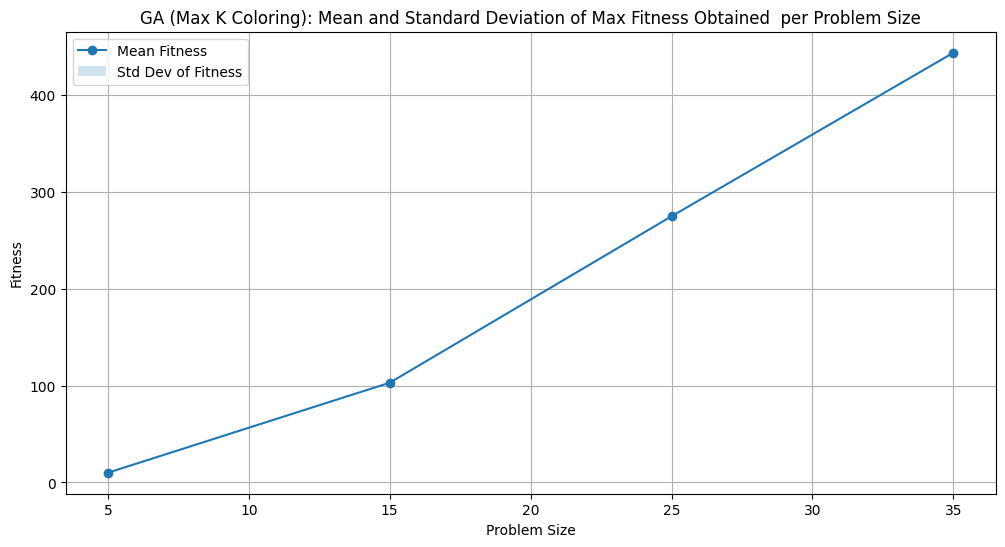

In [178]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(min_iteration_for_max_fitness_ga["problem_size"].unique(), min_iteration_for_max_fitness_ga["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_ga["problem_size"], 
                 min_iteration_for_max_fitness_ga["Average_Fitness"] - min_iteration_for_max_fitness_ga["Std_Fitness"], 
                 min_iteration_for_max_fitness_ga["Average_Fitness"]+ min_iteration_for_max_fitness_ga["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('GA (Max K Coloring): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
plt.show()

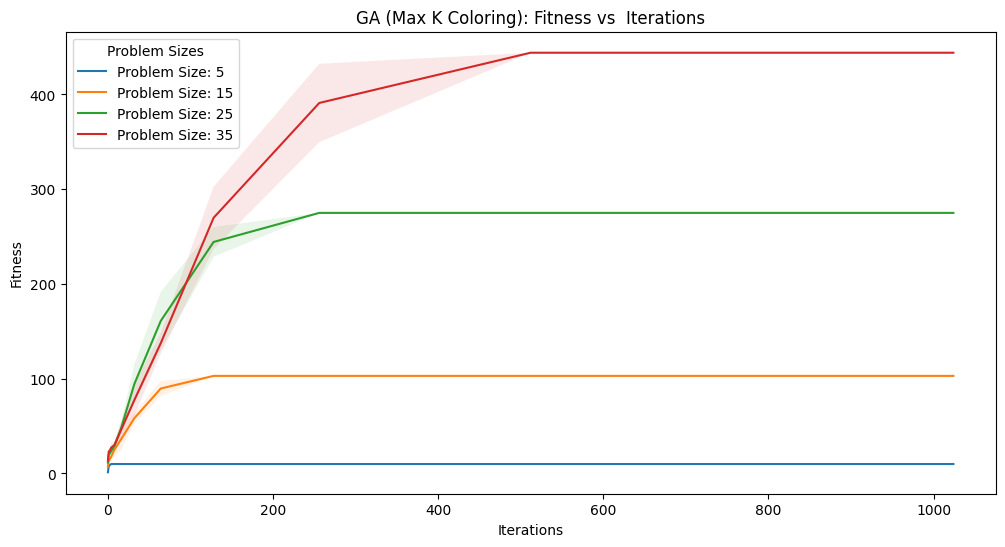

In [179]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    # if best_hyper_params.empty:
    #     continue

    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"] == best_hyper_params["Population Size"].iloc[0]) & 
                      (ga_stats_all["Mutation Rate"] == best_hyper_params["Mutation Rate"].iloc[0])]
    

    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    # if df_grouped.empty:
    #     continue
    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('GA (Max K Coloring): Fitness vs  Iterations')
plt.legend(title='Problem Sizes')
plt.show()


      Unnamed: 0  Iteration  Fitness  FEvals      Time  \
0              0          0      1.0       5  0.000653   
1              1          1      3.0      12  0.003257   
2              2          2      3.0      18  0.005006   
3              3          4      4.0      31  0.007135   
4              4          8      4.0      55  0.009222   
...          ...        ...      ...     ...       ...   
5755         235         64    141.0    3347  0.860246   
5756         236        128    300.0    6630  1.653602   
5757         237        256    444.0   13167  3.083506   
5758         238        512    444.0   21888  4.966523   
5759         239       1024    444.0   21888  4.966523   

                                                  State  Population Size  \
0                                       [3, 4, 0, 1, 3]                5   
1                                       [1, 1, 1, 0, 4]                5   
2                                       [1, 1, 1, 0, 4]                5   

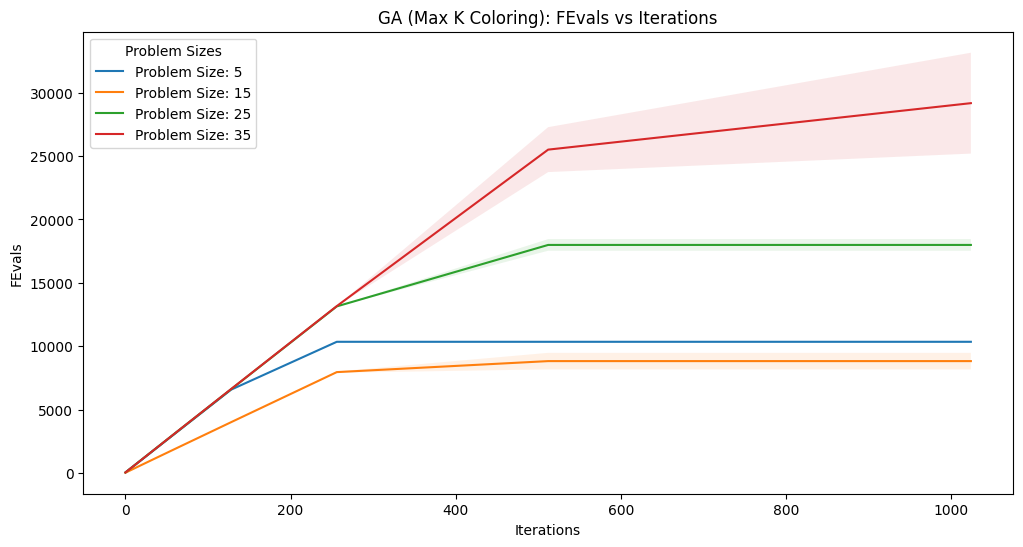

In [180]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]
   
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    # if best_hyper_params.empty:
    #     continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"] == best_hyper_params["Population Size"].iloc[0]) & 
                      (ga_stats_all["Mutation Rate"] == best_hyper_params["Mutation Rate"].iloc[0])]
    print(ga_stats_all)
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('GA (Max K Coloring): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()

In [181]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"].isin(best_hyper_params["Population Size"])) & 
                      (ga_stats_all["Mutation Rate"].isin(best_hyper_params["Mutation Rate"])) &
                        (ga_stats_all["Iteration"].isin(best_hyper_params["Iteration"]))
                        ]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
        # getting grouped std
    grouped_df_std = df.groupby(["problem_size", 'Iteration'])[['Time']].std().reset_index()
    
    max_fitness_first_occurrence_std = grouped_df_std.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    max_fitness_first_occurrence_std.rename(columns={'Time': 'Time Std'}, inplace=True)
    # print(max_fitness_first_occurrence_std.index, max_fitness_first_occurrence.index)
    # merge the two dataframes
    max_fitness_first_occurrence = pd.merge(max_fitness_first_occurrence, max_fitness_first_occurrence_std, on=['problem_size', 'Iteration'])
   
    # print(max_fitness_first_occurrence_std)
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])
# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)
max_fitness_times_all#.dropna(inplace=True)
# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness,Time Std
0,5,4,0.023880,10.0,0.005993
1,15,128,0.361083,103.0,0.025102
2,25,256,2.059149,275.0,0.042204
3,35,512,5.846157,444.0,0.437409


In [182]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"].isin(best_hyper_params["Population Size"])) & 
                      (ga_stats_all["Mutation Rate"].isin(best_hyper_params["Mutation Rate"]))]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])

# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)

# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness
0,5,4,0.023880,10.0
1,15,128,0.361083,103.0
2,25,256,2.059149,275.0
3,35,512,5.846157,444.0


## PLOT FOR All graphs and SIZE = 25

      Unnamed: 0  Iteration  Fitness  FEvals      Time  \
0              0          0      1.0       5  0.000653   
1              1          1      3.0      12  0.003257   
2              2          2      3.0      18  0.005006   
3              3          4      4.0      31  0.007135   
4              4          8      4.0      55  0.009222   
...          ...        ...      ...     ...       ...   
5755         235         64    141.0    3347  0.860246   
5756         236        128    300.0    6630  1.653602   
5757         237        256    444.0   13167  3.083506   
5758         238        512    444.0   21888  4.966523   
5759         239       1024    444.0   21888  4.966523   

                                                  State  Population Size  \
0                                       [3, 4, 0, 1, 3]                5   
1                                       [1, 1, 1, 0, 4]                5   
2                                       [1, 1, 1, 0, 4]                5   

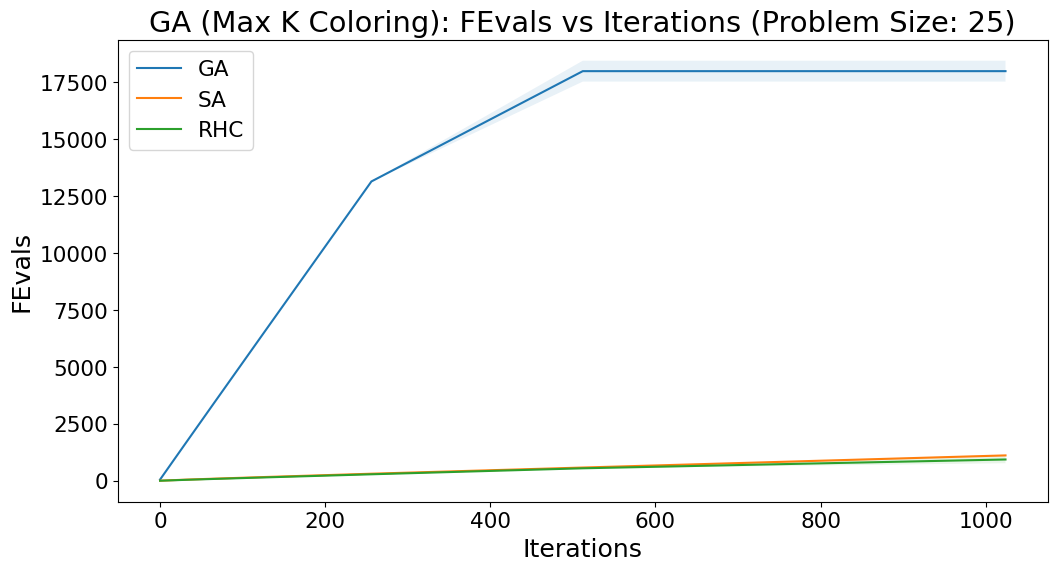

In [191]:
import matplotlib.pyplot as plt
# implement Fevals vs Iterations for all 3 algorithms
# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
size = 25
    # Filter the best hyperparameters for the given problem size
best_hyper_params_ga = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]


# If there are no best hyperparameters for the current problem size, skip this iteration
# if best_hyper_params.empty:
#     continue

# Further filter the main DataFrame for these best hyperparameters
df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                    (ga_stats_all["Population Size"] == best_hyper_params_ga["Population Size"].iloc[0]) & 
                    (ga_stats_all["Mutation Rate"] == best_hyper_params_ga["Mutation Rate"].iloc[0])]
print(ga_stats_all)
# Calculate the mean and standard deviation of FEvals for each iteration
df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()



# Plot the mean FEvals with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"GA")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# plot SA
best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]

# If there are no best hyperparameters for the current problem size, skip this iteration

# Further filter the main DataFrame for these best hyperparameters
df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                    (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                    (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]

# Calculate the mean and standard deviation of FEvals for each iteration
df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()

# If the DataFrame is empty after filtering, skip this iteration

# Plot the mean FEvals with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"SA")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# best_hyper_params_rhc = min_iteration_for_max_fitness_rhc[min_iteration_for_max_fitness_rhc["problem_size"] == size]
# df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) ]

# plt.plot( df["Iteration"], df["FEvals"], label=f"RHC")
# plt.fill_between(df["Iteration"], df["FEvals"] - df["FEvals"], df["FEvals"] + df["FEvals"], alpha=0.1)
    # Filter the best hyperparameters for the given problem size
best_hyper_params = min_iteration_for_max_fitness_rhc[min_iteration_for_max_fitness_rhc["problem_size"] == size]



# Further filter the main DataFrame for these best hyperparameters
df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                ]

# Calculate the mean and standard deviation of FEvals for each iteration
df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()


    
# Plot the mean FEvals with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"RHC")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)


# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title(f'GA (Max K Coloring): FEvals vs Iterations (Problem Size: {size})')
plt.legend(title='RO Algorithm')
increase_font_size(plt)

plt.show()

      Unnamed: 0  Iteration  Fitness  FEvals      Time  \
0              0          0      1.0       0  0.000125   
1              1          1      1.0       2  0.001563   
2              2          2      1.0       4  0.002642   
3              3          4      2.0       8  0.003840   
4              4          8      3.0      15  0.004881   
...          ...        ...      ...     ...       ...   
3451         139         64     11.0     123  0.100380   
3452         140        128     27.0     238  0.134267   
3453         141        256     50.0     420  0.194754   
3454         142        512    105.0     721  0.291483   
3455         143       1024    180.0    1277  0.520239   

                                                  State schedule_type  \
0                                       [3, 4, 0, 1, 3]   exponential   
1                                       [0, 4, 0, 1, 3]   exponential   
2                                       [0, 4, 0, 1, 2]   exponential   
3          

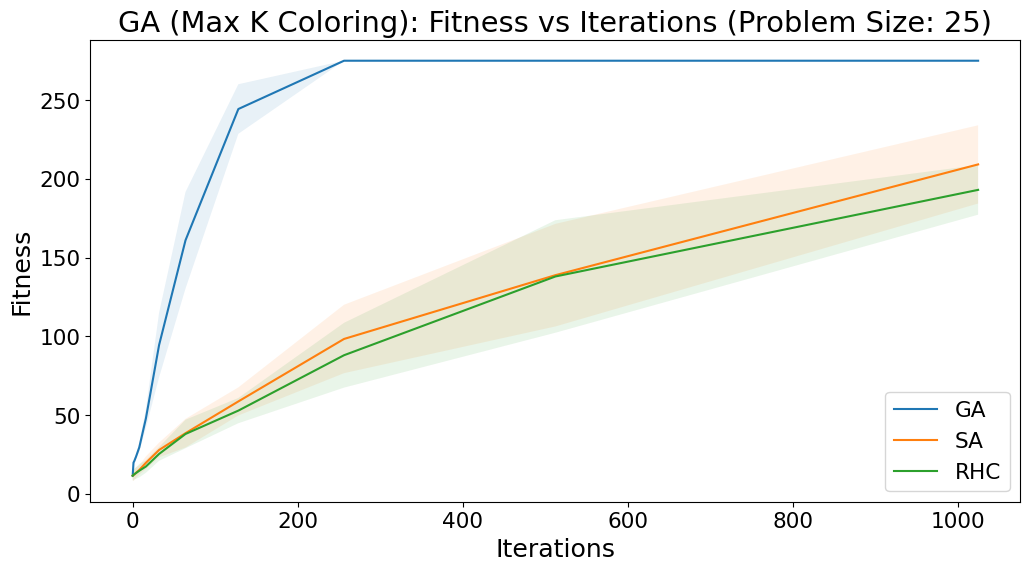

In [190]:
import matplotlib.pyplot as plt
# implement Fitness vs Iterations for all 3 algorithms

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size

size = 25
# Filter the best hyperparameters for the given problem size
best_hyper_params_ga = min_iteration_for_max_fitness_ga[min_iteration_for_max_fitness_ga["problem_size"] == size]


# If there are no best hyperparameters for the current problem size, skip this iteration
# if best_hyper_params.empty:
#     continue

# Further filter the main DataFrame for these best hyperparameters
df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                    (ga_stats_all["Population Size"] == best_hyper_params_ga["Population Size"].iloc[0]) & 
                    (ga_stats_all["Mutation Rate"] == best_hyper_params_ga["Mutation Rate"].iloc[0])]

# Calculate the mean and standard deviation of Fitness for each iteration
df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()

# If the DataFrame is empty after filtering, skip this iteration
# if df_grouped.empty:
#     continue

# Plot the mean fitness with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"GA")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# plot SA
best_hyper_params = min_iteration_for_max_fitness_sa[min_iteration_for_max_fitness_sa["problem_size"] == size]

# If there are no best hyperparameters for the current problem size, skip this iteration

# Further filter the main DataFrame for these best hyperparameters
df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                    (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                    (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]
print(sa_stats_all)
# Calculate the mean and standard deviation of Fitness for each iteration
df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()

# If the DataFrame is empty after filtering, skip this iteration

# Plot the mean fitness with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"SA")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

best_hyper_params = min_iteration_for_max_fitness_rhc[min_iteration_for_max_fitness_rhc["problem_size"] == size]

# Further filter the main DataFrame for these best hyperparameters
df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                ]

# Calculate the mean and standard deviation of FEvals for each iteration
df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()


# Plot the mean FEvals with error bands representing the standard deviation
plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"RHC")
plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

    
# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title(f'GA (Max K Coloring): Fitness vs Iterations (Problem Size: {size})')
plt.legend(title='RO Algorithm')
increase_font_size(plt)

plt.show()


                   


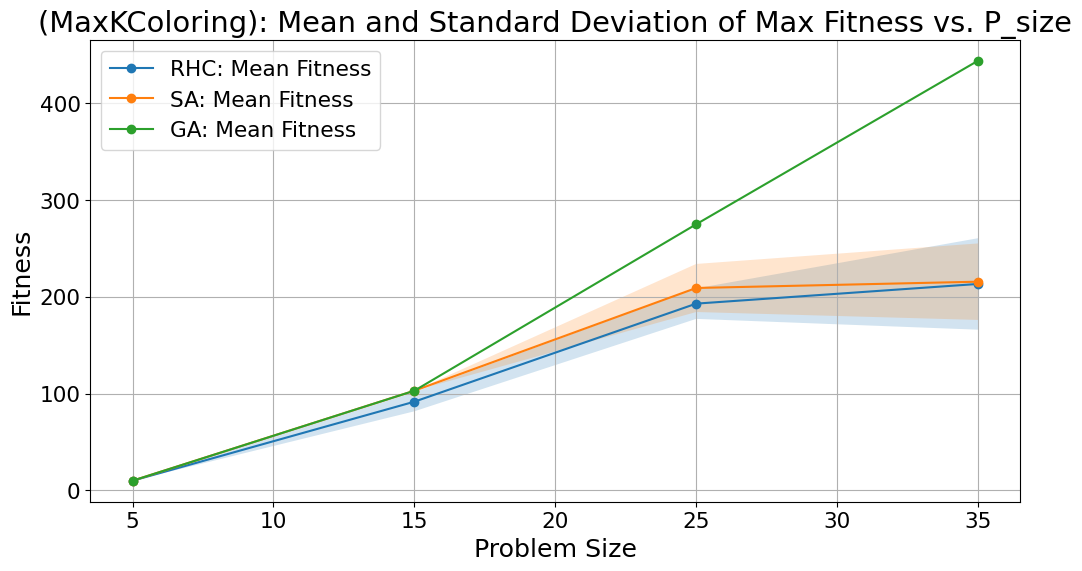

In [189]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(ga_stats_all["problem_size"].unique(), min_iteration_for_max_fitness_rhc["Average_Fitness"], 'o-', label='RHC: Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_rhc["problem_size"], 
                 min_iteration_for_max_fitness_rhc["Average_Fitness"] - min_iteration_for_max_fitness_rhc["Std_Fitness"], 
                 min_iteration_for_max_fitness_rhc["Average_Fitness"]+ min_iteration_for_max_fitness_rhc["Std_Fitness"], 
                 alpha=0.2)



plt.plot(ga_stats_all["problem_size"].unique(), min_iteration_for_max_fitness_sa["Average_Fitness"], 'o-', label='SA: Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_sa["problem_size"], 
                 min_iteration_for_max_fitness_sa["Average_Fitness"] - min_iteration_for_max_fitness_sa["Std_Fitness"], 
                 min_iteration_for_max_fitness_sa["Average_Fitness"]+ min_iteration_for_max_fitness_sa["Std_Fitness"], 
                 alpha=0.2)

plt.plot(ga_stats_all["problem_size"].unique(), min_iteration_for_max_fitness_ga["Average_Fitness"], 'o-', label='GA: Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness_ga["problem_size"], 
                 min_iteration_for_max_fitness_ga["Average_Fitness"] - min_iteration_for_max_fitness_ga["Std_Fitness"], 
                 min_iteration_for_max_fitness_ga["Average_Fitness"]+ min_iteration_for_max_fitness_ga["Std_Fitness"], 
                 alpha=0.2)

plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('(MaxKColoring): Mean and Standard Deviation of Max Fitness vs. P_size' )
plt.legend()
plt.grid(True)
increase_font_size(plt)

plt.show()

plt.